In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

from torchvision import datasets, transforms 
from torchvision.utils import make_grid

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
BATCH_SIZE = 32
NUM_EPOCHS = 10
LATENTS = 20

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True)

In [0]:
class VAE(nn.Module):

  def __init__(self):
    super(VAE, self).__init__()
    self.fc1  = nn.Linear(28*28, 512)
    self.fc21 = nn.Linear(512, LATENTS)
    self.fc22 = nn.Linear(512, LATENTS)
    self.fc3  = nn.Linear(LATENTS, 512)
    self.fc4  = nn.Linear(512, 28*28)

  def encode(self, x):
    h1 = F.relu(self.fc1(x))
    return self.fc21(h1), self.fc22(h1)
  
  def reparam(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)

  def decode(self, z):
    h3 = F.relu(self.fc3(z))
    return torch.sigmoid(self.fc4(h3))

  def forward(self, x):
    mu, logvar = self.encode(x.view(-1, 28*28))
    z = self.reparam(mu, logvar)
    return self.decode(z), mu, logvar

model = VAE()

In [0]:
model = model.to(device)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [0]:
def loss_fcn(pred, truth, mu, logvar):
  BCE = F.binary_cross_entropy(pred, truth.view(-1, 28*28), reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE + KLD

In [0]:
def train(epoch, verbose=False, interval=25): 
  model.train()
  train_loss = 0

  for batch_idx, (data, _) in enumerate(train_loader):

    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)
    loss = loss_fcn(recon_batch, data, mu, logvar) 
    loss.backward()
    train_loss += loss.item()
    optimizer.step()


    if verbose and batch_idx % interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'\
            .format( epoch, batch_idx * len(data), len(train_loader.dataset),\
                     100. * batch_idx / len(train_loader), loss.item() / len(data)))
  
  train_loss /= len(train_loader.dataset)
  print('====> Epoch: {} Average loss: {:.4f}'.format( epoch, train_loss))
  return train_loss

In [0]:
def test(epoch):
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
      data = data.to(device)
      recon_batch, mu, logvar = model(data)
      test_loss += loss_fcn(recon_batch, data, mu, logvar).item()

      if i == 0:
        n = min(data.size(0), 8)
        comparison = torch.cat([data[:n],
                              recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])

        print("===================================")
        print("=== Reconstruction ")
        x = make_grid(comparison.cpu())
        plt.imshow(np.transpose(x, (1, 2, 0)))
        plt.show()

  test_loss /= len(test_loader.dataset)
  print('====> Test set loss: {:.4f}'.format(test_loss))
  return test_loss

====> Epoch: 1 Average loss: 133.2281
=== Reconstruction 


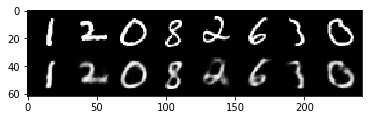

====> Test set loss: 113.6628
=== Sample 


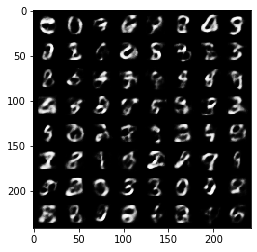

====> Epoch: 2 Average loss: 112.0286
=== Reconstruction 


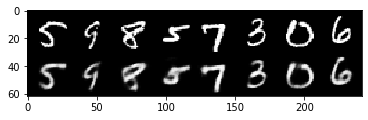

====> Test set loss: 109.1070
=== Sample 


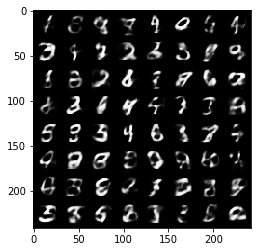

====> Epoch: 3 Average loss: 109.2160
=== Reconstruction 


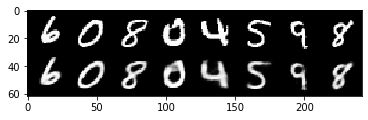

====> Test set loss: 107.4338
=== Sample 


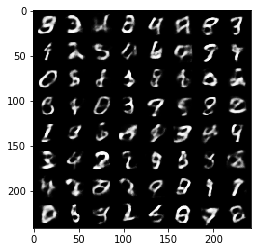

====> Epoch: 4 Average loss: 107.8100
=== Reconstruction 


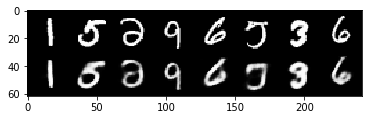

====> Test set loss: 106.9051
=== Sample 


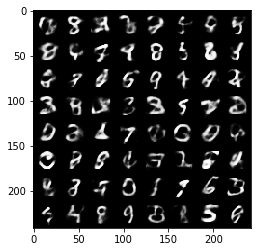

====> Epoch: 5 Average loss: 106.9603
=== Reconstruction 


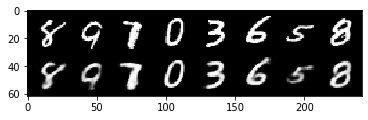

====> Test set loss: 106.4068
=== Sample 


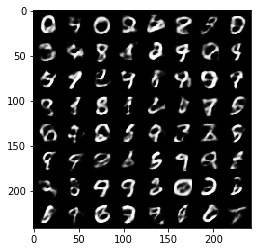

====> Epoch: 6 Average loss: 106.3049
=== Reconstruction 


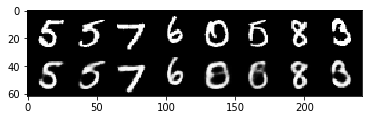

====> Test set loss: 105.4489
=== Sample 


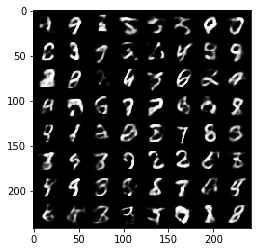

====> Epoch: 7 Average loss: 105.8310
=== Reconstruction 


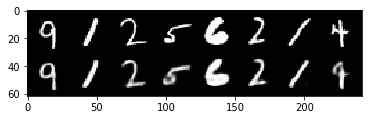

====> Test set loss: 105.3925
=== Sample 


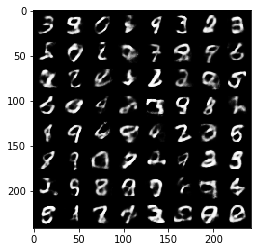

====> Epoch: 8 Average loss: 105.4466
=== Reconstruction 


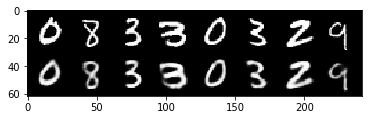

====> Test set loss: 105.2655
=== Sample 


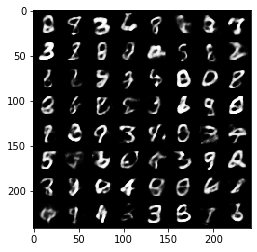

====> Epoch: 9 Average loss: 105.0789
=== Reconstruction 


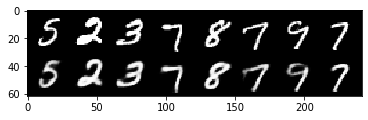

====> Test set loss: 105.1314
=== Sample 


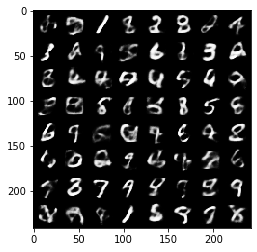

====> Epoch: 10 Average loss: 104.8130
=== Reconstruction 


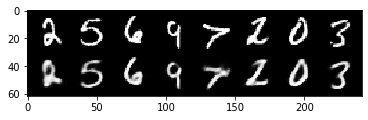

====> Test set loss: 104.4409
=== Sample 


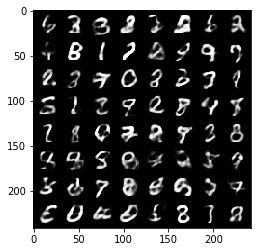

In [0]:
train_losses = []
test_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
  train_loss = train(epoch)
  train_losses.append(train_loss)

  test_loss  = test(epoch)
  test_losses.append(test_loss)

  with torch.no_grad():
    sample = torch.randn(64, LATENTS).to(device)
    sample = model.decode(sample).cpu()

    print("===================================")
    print("=== Sample ")
    x = sample.view(64, 1, 28, 28)
    x = make_grid(x)
    plt.imshow(np.transpose(x, (1, 2, 0)))
    plt.show()

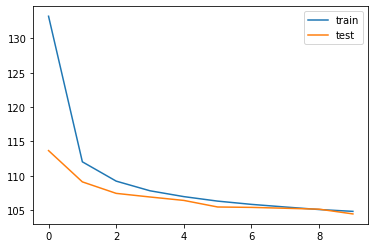

In [0]:
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()